STEP 5: LSTM Model Training and Evaluation
This step loads preprocessed sequences, builds an LSTM model to predict next-hour traffic density, trains and validates the model, and saves the trained model for future inference.

In [1]:
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
# Load sequences
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load scaler (optional, for inverse transform later)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (464, 48, 7)
y_train shape: (464,)
X_test shape: (80, 48, 7)
y_test shape: (80,)


In [3]:
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.15),

    LSTM(48),
    Dropout(0.15),

    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
model.summary()

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 96)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,825 (264.94 KB)

 Trainable params: 67,825 (264.94 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5
)


In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1685 - mae: 0.3330 - val_loss: 0.0893 - val_mae: 0.2627 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0424 - mae: 0.1627 - val_loss: 0.0802 - val_mae: 0.2361 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0361 - mae: 0.1484 - val_loss: 0.0765 - val_mae: 0.2301 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0376 - mae: 0.1557 - val_loss: 0.0761 - val_mae: 0.2220 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0352 - mae: 0.1457 - val_loss: 0.0733 - val_mae: 0.2313 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0400 - mae: 0.1577 - val_loss: 0.0733 - val_mae: 0.2274 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0332 - mae: 0.1467 - val_loss: 0.0736 - val_mae: 0.2252 - learning_rate: 0.0010
Epoch 

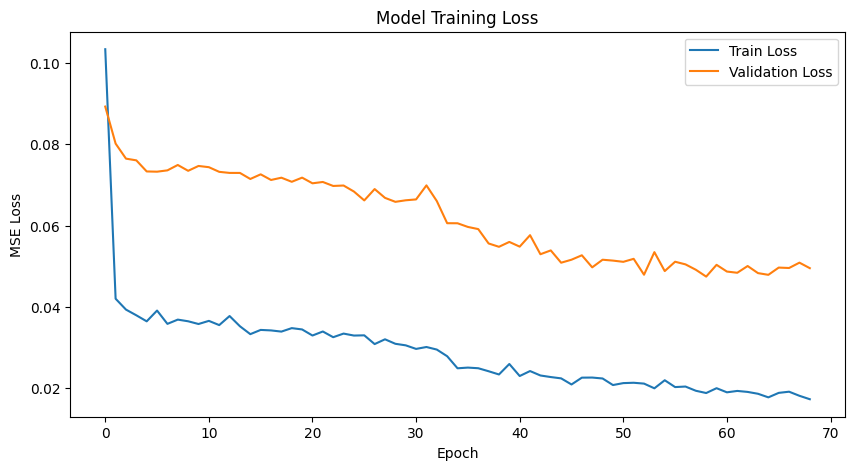

In [6]:
# Plot Training History
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [7]:
# Evaluate Model on Test Set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0496 - mae: 0.1875 
Test Loss (MSE): 0.047433771193027496
Test MAE: 0.18169790506362915


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


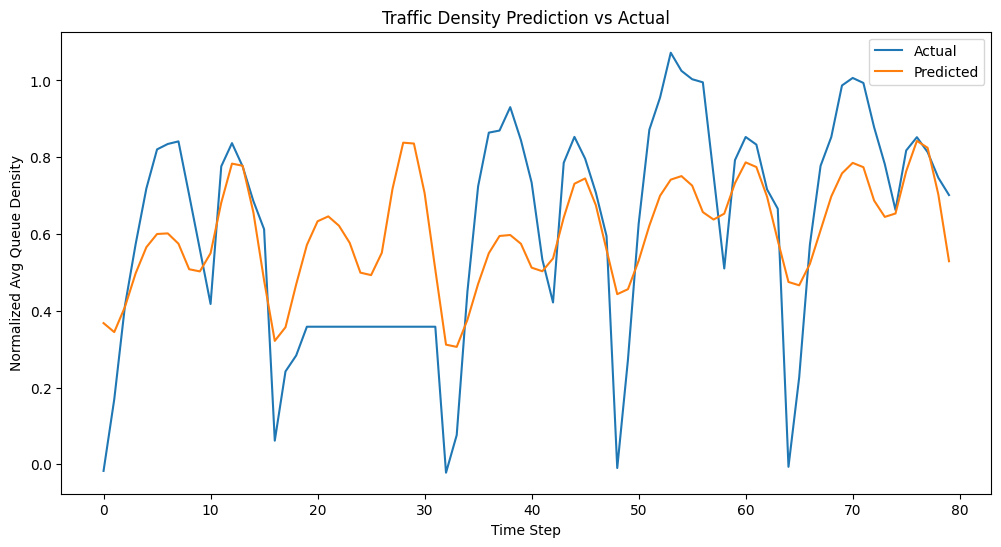

In [8]:
# Make Predictions and Inverse Transform
y_pred = model.predict(X_test)

# If you want real-scale predictions
# y_pred_real = scaler.inverse_transform(np.concatenate([y_pred, X_test[:, -1, 1:]], axis=1))[:,0]
# y_test_real = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), X_test[:, -1, 1:]], axis=1))[:,0]

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Traffic Density Prediction vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Normalized Avg Queue Density")
plt.legend()
plt.show()


In [9]:
import os

os.makedirs("models", exist_ok=True)


In [10]:
model.save("models/lstm_traffic_model.keras")
print("Trained LSTM model saved successfully.")


Trained LSTM model saved successfully.


Outcome of STEP 5:
An LSTM model was trained to predict next-hour traffic density.
The model was evaluated on a test set and visualized predictions versus actual traffic.
The trained model was saved as lstm_traffic_model.h5 for future inference in the frontend application.